In [1]:
from datetime import datetime
import json
import numpy as np
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Optional: prevent column truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  # Auto-detect width

def now():
    now = datetime.now()
    yyyymmdd_hhmmss_part = now.strftime('%Y-%m-%d %H:%M:%S')
    ms_part = f'{int(now.microsecond / 1000):03d}'
    return f'{yyyymmdd_hhmmss_part},{ms_part}'

def get_full_shape(df_filename):
    df = pd.read_parquet(df_filename)
    n_rows, n_cols = df.shape
    n_cols -= 1 # discard target
    n_labels = df['label'].nunique()
    return n_rows, n_cols, n_labels

def get_dtypes(df_filename):
    df = pd.read_parquet(df_filename).drop(columns=['label'])
    dtypes = set([str(x) for x in df.dtypes.tolist()])

    numerical_types = {'int8', 'int16', 'int32', 'int64',
                       'uint8', 'uint16', 'uint32', 'uint64',
                       'float16', 'float32', 'float64'}
    categorical_types = {'category'}

    if dtypes.issubset(numerical_types):
        feature_type = 'numerical'
    elif dtypes.issubset(categorical_types):
        feature_type = 'categorical'
    elif dtypes & numerical_types and dtypes & categorical_types:
        feature_type = 'mixed'
    else:
        feature_type = 'unknown'  # catch-all for object, bool, etc.

    return dtypes, feature_type

In [2]:
from pathlib import Path
from time import sleep
from tqdm.notebook import tqdm
import os
import papermill as pm

In [3]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Input_Multiclass")

file_sizes = {}
shapes = {}
dtypes = {}
feature_types = {}

# Find all .parquet files recursively
parquet_files = list(base_folder.rglob("*.parquet"))

# Sort by file size (ascending)
parquet_files_sorted = sorted(parquet_files, key=lambda p: os.path.getsize(p))

# Iterate
for file in tqdm(parquet_files_sorted, desc='File', leave='False'):

    try:
        file_sizes[file.stem] = os.path.getsize(file) / 1024 / 1024
        shapes[file.stem] = get_full_shape(file)
        _dtypes, _feature_types = get_dtypes(file)
        dtypes[file.stem] = _dtypes
        feature_types[file.stem] = _feature_types
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/75 [00:00<?, ?it/s]

In [4]:
custom_order = [
    "CIC_IDS_2017_Multiclass",
    "CIC_IOT_Dataset2023_Multiclass",
    "IoT_23_Multiclass",
    "IoT_Network_Intrusion_Macro_Multiclass",
    "IoT_Network_Intrusion_Micro_Multiclass",
    "KDD_Cup_1999_Multiclass",
    "UNSW_NB15_Multiclass",
    "BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass",
    "BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoMT-2024_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2023-Original_Training_and_Testing_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-HCRL-2019_Multiclass",
    "BCCC_CIC-BCCC-NRC-MQTTIoT-IDS-2020_Multiclass",
    "BCCC_CIC-BCCC-NRC-TONIoT-2021_Multiclass",
    "BCCC_CIC-BCCC-NRC-UQ-IOT-2022_Multiclass",
    "BoT_IoT_Macro_Multiclass",
    "BoT_IoT_Micro_Multiclass",
    "CICAPT_IIoT_Phase1_Macro_Multiclass", # nok
    "CICAPT_IIoT_Phase1_Micro_Multiclass", # nok
    "CICAPT_IIoT_Phase2_Macro_Multiclass",
    "CICAPT_IIoT_Phase2_Micro_Multiclass",
    "CICEVSE2024_EVSE-A_Macro_Multiclass",
    "CICEVSE2024_EVSE-A_Micro_Multiclass",
    "CICEVSE2024_EVSE-B_Macro_Multiclass",
    "CICEVSE2024_EVSE-B_Micro_Multiclass",
    "CICIoMT2024_Bluetooth_Multiclass",
    "CICIoMT2024_WiFi_and_MQTT_Multiclass",
    "CICIoV2024_Decimal_Macro_Multiclass",
    "CICIoV2024_Decimal_Micro_Multiclass",
    "EDGE-IIOTSET_DNN-EdgeIIoT_Multiclass",
    "EDGE-IIOTSET_ML-EdgeIIoT_Multiclass",
    "MQTT_IoT_IDS2020_BiflowFeatures_Multiclass",
    "MQTT_IoT_IDS2020_PacketFeatures_Multiclass",
    "MQTT_IoT_IDS2020_UniflowFeatures_Multiclass",
    "NIDS_CIC-BoT-IoT_Multiclass",
    "NIDS_CIC-ToN-IoT_Multiclass",
    "NIDS_NF-BoT-IoT_Multiclass",
    "NIDS_NF-BoT-IoT-v2_Multiclass",
    "NIDS_NF-BoT-IoT-v3_Multiclass",
    "NIDS_NF-CICIDS2018-v3_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018-v2_Multiclass",
    "NIDS_NF-ToN-IoT_Multiclass",
    "NIDS_NF-ToN-IoT-v2_Multiclass",
    "NIDS_NF-ToN-IoT-v3_Multiclass",
    "NIDS_NF-UNSW-NB15_Multiclass",
    "NIDS_NF-UNSW-NB15-v2_Multiclass",
    "NIDS_NF-UNSW-NB15-v3_Multiclass",
    "NIDS_NF-UQ-NIDS_Multiclass",
    "NIDS_NF-UQ-NIDS-v2_Multiclass",
    "N_BaIoT_Danmini_Doorbell_Multiclass",
    "N_BaIoT_Ecobee_Thermostat_Multiclass",
    "N_BaIoT_Ennio_Doorbell_Multiclass",
    "N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass",
    "N_BaIoT_Provision_PT_737E_Security_Camera_Multiclass",
    "N_BaIoT_Provision_PT_838_Security_Camera_Multiclass",
    "N_BaIoT_Samsung_SNH_1011_N_Webcam_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1002_WHT_Security_Camera_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass",
    "ToN_IoT_IoT_Fridge_Multiclass",
    "ToN_IoT_IoT_GPS_Tracker_Multiclass",
    "ToN_IoT_IoT_Garage_Door_Multiclass",
    "ToN_IoT_IoT_Modbus_Multiclass",
    "ToN_IoT_IoT_Motion_Light_Multiclass", # nok
    "ToN_IoT_IoT_Thermostat_Multiclass",
    "ToN_IoT_IoT_Weather_Multiclass",
    "ToN_IoT_Linux_Disk_Multiclass",
    "ToN_IoT_Linux_Memory_Multiclass",
    "ToN_IoT_Linux_Process_Multiclass",
    "ToN_IoT_Network_Multiclass",
    "ToN_IoT_Windows_10_Multiclass",
    "ToN_IoT_Windows_7_Multiclass"
]

In [5]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Input_Multiclass")

metrics_folder = Path(str(base_folder).replace('/Input_Multiclass', '/Output_Multiclass/100_pct'))

def get_metrics(dataset_name):
    metrics_filename = os.path.join(
        metrics_folder, f'{dataset_name}_complexity.json'
    )
    with open(metrics_filename, 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics

def get_overall_difficulty(dataset_name):
    with open('df_ordered.json', 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics.get(dataset_name, {}).get('overall_difficulty', np.nan)

print(get_overall_difficulty('ToN_IoT_Windows_7_Multiclass'))

0.4691121808


In [6]:
# Build the DataFrame
df_raw = pd.DataFrame({
    'size_mb': file_sizes,
    'samples': {k: v[0] for k, v in shapes.items()}, 
    'features': {k: v[1] for k, v in shapes.items()},
    'classes': {k: v[2] for k, v in shapes.items()},
    'dtypes': dtypes,
    'feature_types': feature_types
})

# Set index using the row labels (i.e., filenames)
df_raw.index.name = "filename"

df_raw['overall_difficulty'] = df_raw.index.to_series().apply(get_overall_difficulty)

# Filter custom_order to only include datasets that exist in the DataFrame
valid_order = [d for d in custom_order if d in df_raw.index]

# Reorder using the filtered list
df_raw = df_raw.loc[valid_order]

# Now you can style it
input_df = df_raw.style.format({
    'size_mb': '{:.2f}',
    'samples': '{:,.0f}'
})

input_df

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty
filename,,,,,,,
CIC_IDS_2017_Multiclass,48.12,"1,250,066",70,15,"{'int64', 'int32', 'category'}",mixed,0.516218
CIC_IOT_Dataset2023_Multiclass,103.47,"4,487,800",39,35,"{'float64', 'float32', 'int64', 'int32', 'category'}",mixed,0.463669
IoT_23_Multiclass,1.98,"363,889",12,16,"{'float32', 'int32', 'category'}",mixed,0.654002
IoT_Network_Intrusion_Macro_Multiclass,0.39,"78,938",24,5,"{'float64', 'int32', 'category'}",mixed,0.581516
IoT_Network_Intrusion_Micro_Multiclass,0.39,"78,963",24,11,"{'float64', 'int32', 'category'}",mixed,0.578433
KDD_Cup_1999_Multiclass,6.02,"1,074,992",40,23,"{'int64', 'float32', 'int32', 'category'}",mixed,0.533156
UNSW_NB15_Multiclass,46.29,"1,944,769",45,11,"{'float64', 'float32', 'int64', 'int32', 'category'}",mixed,0.597476
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.34,"292,898",73,12,"{'float64', 'float32', 'int64', 'int32', 'category'}",mixed,0.572254
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.41,"1,175,500",69,12,"{'float64', 'float32', 'int64', 'int32', 'category'}",mixed,0.519524


In [7]:
def format_and_pad_all_columns(df):
    df_str = df.copy()

    # Format columns by type
    for col in df_str.columns:
        if pd.api.types.is_float_dtype(df_str[col]):
            if 'time' in col:
                df_str[col] = df_str[col].map(lambda x: f"{x:,.1f}")
            elif 'size' in col:
                df_str[col] = df_str[col].map(lambda x: f"{x:,.2f}")
            else:
                df_str[col] = df_str[col].map(lambda x: f"{x:,.3f}")
        elif pd.api.types.is_integer_dtype(df_str[col]):
            df_str[col] = df_str[col].map(lambda x: f"{x:,}")
        else:
            df_str[col] = df_str[col].astype(str)

    # Pad each column with spaces to align visually
    for col in df_str.columns:
        max_len = df_str[col].map(len).max()
        df_str[col] = df_str[col].map(lambda x: x.ljust(max_len))

    return df_str

# Apply to your DataFrame
df_pretty = format_and_pad_all_columns(df_raw.loc[custom_order]).drop(columns=['size_mb', 'dtypes'])

# df_pretty.index = df_pretty.index.str.replace('_Multiclass', '', regex=False)

# Export to .tex with aligned source formatting
# df_pretty.to_latex("table_2.tex", header=True, index=True, escape=False)
with open("table_2.tex", "w") as f:
    f.write(df_pretty.to_string())

df_pretty

,samples,features,classes,feature_types,overall_difficulty
filename,,,,,
CIC_IDS_2017_Multiclass,"1,250,066",70,15,mixed,0.516
CIC_IOT_Dataset2023_Multiclass,"4,487,800",39,35,mixed,0.464
IoT_23_Multiclass,"363,889",12,16,mixed,0.654
IoT_Network_Intrusion_Macro_Multiclass,"78,938",24,5,mixed,0.582
IoT_Network_Intrusion_Micro_Multiclass,"78,963",24,11,mixed,0.578
KDD_Cup_1999_Multiclass,"1,074,992",40,23,mixed,0.533
UNSW_NB15_Multiclass,"1,944,769",45,11,mixed,0.597
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,"292,898",73,12,mixed,0.572
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,"1,175,500",69,12,mixed,0.520


In [8]:
df_pretty.shape

(73, 5)

In [9]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full")

def get_model_size(dataset_name, stage):
    ds_folder = os.path.join(base_folder, dataset_name)
    model_filename = os.path.join(ds_folder, f'xgb_{stage}_model.json')
    size_bytes = os.path.getsize(model_filename)
    return size_bytes

def get_scores(dataset_name, stage):
    results = {}
    ds_folder = os.path.join(base_folder, dataset_name)
    if stage.lower() in ['full', 'sampled', 'reduced', 'filtered']:
        metric_filename = os.path.join(ds_folder, f'xgb_{stage.lower()}_metrics.json')
        try:
            with open(metric_filename, 'r', encoding='utf-8') as fp:
                results = json.load(fp)
        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {}
    elif stage.lower() == 'hpo':
        metric_filename = os.path.join(ds_folder, 'xgb_hpo_trials.xlsx')
        try:
            results_df = pd.read_excel(metric_filename).dropna()
            
            # Convert datetime columns to actual datetime objects
            results_df["datetime_start"] = pd.to_datetime(results_df["datetime_start"])
            results_df["datetime_complete"] = pd.to_datetime(results_df["datetime_complete"])
            
            # Calculate training time as a new column
            results_df["training_time_sec"] = (results_df["datetime_complete"] - results_df["datetime_start"]).dt.total_seconds()

            model_sizes = [
                get_model_size(dataset_name, 'best_balance') / 1024 / 1024,
                get_model_size(dataset_name, 'best_latency') / 1024 / 1024,
                get_model_size(dataset_name, 'best_weighted_f1_score') / 1024 / 1024,
            ]
            
            results = {
                'training_time': {
                    'min': results_df['training_time_sec'].min(),
                    'max': results_df['training_time_sec'].max(),
                    'mean': results_df['training_time_sec'].mean(),
                    'std': results_df['training_time_sec'].std(),
                },
                'latency': {
                    'min': results_df['latency'].min(),
                    'max': results_df['latency'].max(),
                    'mean': results_df['latency'].mean(),
                    'std': results_df['latency'].std(),
                },
                'f1_score': {
                    'min': results_df['f1_score'].min(),
                    'max': results_df['f1_score'].max(),
                    'mean': results_df['f1_score'].mean(),
                    'std': results_df['f1_score'].std(),
                },
                'size': {
                    'min': np.min(model_sizes),
                    'max': np.max(model_sizes),
                    'mean': np.mean(model_sizes),
                    'std': np.std(model_sizes),
                }
            }
        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {
                'training_time': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'latency': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'f1_score': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'size': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                }
            }
    return results

for stage in ['full', 'sampled', 'reduced', 'filtered']:
    print(stage, get_scores('KDD_Cup_1999_Multiclass', stage), '\n')

print('hpo', get_scores('KDD_Cup_1999_Multiclass', 'hpo'), '\n')

full {'accuracy': 0.9997999990697631, 'balanced_accuracy': 0.7806832556202591, 'mcc': 0.999470146976705, 'cohen_kappa': 0.9994701224482787, 'precision_micro': 0.9997999990697631, 'recall_micro': 0.9997999990697631, 'f1_micro': 0.9997999990697631, 'precision_macro': 0.8202571305646795, 'recall_macro': 0.7806832556202591, 'f1_macro': 0.7920855963925386, 'precision_weighted': 0.9997749763378312, 'recall_weighted': 0.9997999990697631, 'f1_weighted': 0.9997845584213136, 'log_loss': 0.000894361642066211, 'roc_auc_ovr_micro': nan, 'roc_auc_ovo_micro': nan, 'roc_auc_ovr_macro': 0.9999577869344055, 'roc_auc_ovo_macro': 0.976270743618668, 'roc_auc_ovr_weighted': 0.9999993743827758, 'roc_auc_ovo_weighted': 0.9999559765230411, 'training_time': 13.017459392547607, 'test_time': 0.08771181106567383, 'latency': 4.0796380943945706e-07, 'model_size': 2.34} 

sampled {'accuracy': 0.9994511602379546, 'balanced_accuracy': 0.7547325664787659, 'mcc': 0.9985456947834608, 'cohen_kappa': 0.9985455107115699, 'pr

In [10]:
for dataset_name in df_pretty.index:
    try:
        # Extract metrics
        new_data = {
            # f1 scores
            'f1_full': get_scores(dataset_name, 'full').get('f1_weighted', np.nan),
            'f1_sampled': get_scores(dataset_name, 'sampled').get('f1_weighted', np.nan),
            'f1_reduced': get_scores(dataset_name, 'reduced').get('f1_weighted', np.nan),
            'f1_filtered': get_scores(dataset_name, 'filtered').get('f1_weighted', np.nan),
            'f1_hpo_min': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('min', np.nan),
            'f1_hpo_max': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('max', np.nan),
            'f1_hpo_mean': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('mean', np.nan),
            'f1_hpo_std': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('std', np.nan),
            # training times
            'time_full': get_scores(dataset_name, 'full').get('training_time', np.nan),
            'time_sampled': get_scores(dataset_name, 'sampled').get('training_time', np.nan),
            'time_reduced': get_scores(dataset_name, 'reduced').get('training_time', np.nan),
            'time_filtered': get_scores(dataset_name, 'filtered').get('training_time', np.nan),
            'time_hpo_min': get_scores(dataset_name, 'hpo').get('training_time', {}).get('min', np.nan),
            'time_hpo_max': get_scores(dataset_name, 'hpo').get('training_time', {}).get('max', np.nan),
            'time_hpo_mean': get_scores(dataset_name, 'hpo').get('training_time', {}).get('mean', np.nan),
            'time_hpo_std': get_scores(dataset_name, 'hpo').get('training_time', {}).get('std', np.nan),
            # size
            'size_full': get_scores(dataset_name, 'full').get('model_size', np.nan),
            'size_sampled': get_scores(dataset_name, 'sampled').get('model_size', np.nan),
            'size_reduced': get_scores(dataset_name, 'reduced').get('model_size', np.nan),
            'size_filtered': get_scores(dataset_name, 'filtered').get('model_size', np.nan),
            'size_hpo_min': get_scores(dataset_name, 'hpo').get('size', {}).get('min', np.nan),
            'size_hpo_max': get_scores(dataset_name, 'hpo').get('size', {}).get('max', np.nan),
            'size_hpo_mean': get_scores(dataset_name, 'hpo').get('size', {}).get('mean', np.nan),
            'size_hpo_std': get_scores(dataset_name, 'hpo').get('size', {}).get('std', np.nan),
        }

        # Assign values into the existing df_pretty using .at
        for col, val in new_data.items():
            df_pretty.at[dataset_name, col] = val

    except Exception as e:
        print(f"Skipping {dataset_name} due to: {e}")
        # pass

df_pretty

Could not open /home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass/xgb_full_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass/xgb_full_metrics.json'
Could not open /home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass/xgb_sampled_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass/xgb_sampled_metrics.json'
Could not open /home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass/xgb_reduced_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-03/Output_Multiclass_Base_Full/BCCC_CIC-BCCC-NRC-IoT-2022_Multicla

,samples,features,classes,feature_types,overall_difficulty,f1_full,f1_sampled,f1_reduced,f1_filtered,f1_hpo_min,f1_hpo_max,f1_hpo_mean,f1_hpo_std,time_full,time_sampled,time_reduced,time_filtered,time_hpo_min,time_hpo_max,time_hpo_mean,time_hpo_std,size_full,size_sampled,size_reduced,size_filtered,size_hpo_min,size_hpo_max,size_hpo_mean,size_hpo_std
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,"1,250,066",70,15,mixed,0.516,0.999263,0.998707,0.996949,0.992641,0.584204,0.990477,0.915231,0.086178,7.166415,7.578830,9.598269,3.281537,4.323,10.189,6.950590,1.248334,2.70,2.48,2.23,0.86,0.093390,1.712855,0.850230,0.665362
CIC_IOT_Dataset2023_Multiclass,"4,487,800",39,35,mixed,0.464,0.768569,0.749499,0.720069,0.632341,0.557552,0.746783,0.685897,0.046341,123.285117,37.984528,35.929233,6.678245,13.956,33.001,21.443591,5.629646,52.26,15.24,11.45,2.94,0.217858,6.115209,3.772257,2.555437
IoT_23_Multiclass,"363,889",12,16,mixed,0.654,0.992632,0.990753,0.989082,0.880036,0.626274,0.953602,0.839270,0.070567,8.183706,5.915528,6.492728,2.071164,4.036,11.310,6.465978,1.392219,2.67,1.33,1.64,0.57,0.099537,3.783819,1.465414,1.648022
IoT_Network_Intrusion_Macro_Multiclass,"78,938",24,5,mixed,0.582,0.916200,0.912424,0.913172,0.876298,0.681926,0.887332,0.804820,0.052903,2.810583,2.168461,1.967618,1.975679,2.081,7.931,3.170779,0.944838,1.51,0.58,0.54,0.41,0.031631,0.414261,0.259564,0.164569
IoT_Network_Intrusion_Micro_Multiclass,"78,963",24,11,mixed,0.578,0.914868,0.910227,0.910547,0.876966,0.470751,0.938856,0.839968,0.088297,6.259300,2.806388,2.619953,2.365293,3.273,12.184,5.937972,1.921872,2.29,0.79,0.87,0.60,0.068828,1.583953,0.704916,0.641960
KDD_Cup_1999_Multiclass,"1,074,992",40,23,mixed,0.533,0.999785,0.999443,0.968254,0.198343,0.081338,0.967500,0.757744,0.237079,13.017459,8.614185,5.155562,1.071526,3.274,13.882,6.233730,2.275304,2.34,1.71,1.30,0.30,0.154978,0.371634,0.252845,0.089678
UNSW_NB15_Multiclass,"1,944,769",45,11,mixed,0.597,0.982184,0.980002,0.980519,0.977220,0.724340,0.973682,0.914242,0.049421,4.949307,3.844372,3.673512,3.117624,3.459,13.749,6.897138,1.676478,3.13,1.76,1.65,1.57,0.068789,1.026696,0.618790,0.403766
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,"292,898",73,12,mixed,0.572,0.755286,0.734931,0.733061,0.606764,0.407718,0.582377,0.528422,0.030473,25.048883,5.822561,4.287917,3.624256,6.603,14.081,9.221311,1.803869,10.69,2.16,2.35,1.68,0.075767,1.039275,0.623035,0.404115
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,"1,175,500",69,12,mixed,0.520,0.999140,0.998761,0.998053,0.992122,0.813780,0.991456,0.955322,0.033191,4.753864,3.082714,3.929155,8.960837,4.766,11.100,6.248819,1.031125,1.22,0.80,0.90,2.33,0.075236,3.757674,2.291991,1.594400


In [11]:
df_pretty.shape

(73, 29)

In [12]:
df_super_pretty = format_and_pad_all_columns(df_pretty.loc[custom_order])
with open("df_super_pretty.tex", "w") as f:
    f.write(df_super_pretty.to_string())

# $F_1$ Score Analysis

In [13]:
# Columns to compare against "full"
cols_to_compare = ['f1_sampled', 'f1_reduced', 'f1_filtered', 'f1_hpo_max', 'f1_hpo_mean']

# Make a numeric copy to compute differences safely
df_numeric = df_pretty.copy()

# Compute best alternative and delta
# best_alternative = df_numeric[cols_to_compare].max(axis=1)
# df_pretty['f1_delta_abs'] = best_alternative - df_numeric['f1_full']
# df_pretty['f1_delta_pct'] = df_pretty['f1_delta_abs'] / df_numeric['f1_full']

# # Enforce +/- signs and percentage for 2nd col
# df_pretty['f1_delta_abs'] = df_pretty['f1_delta_abs'].map(lambda x: f"{x:+.3f}")
# df_pretty['f1_delta_pct'] = df_pretty['f1_delta_pct'].apply(lambda x: f"{x * 100:+.2f}")

# Apply to your DataFrame
df_pretty = format_and_pad_all_columns(df_pretty.loc[custom_order])

# Export to .tex with aligned source formatting
# df_pretty.to_latex("table_3.tex", header=True, index=True, escape=False)
selected_cols = ["f1_full", "f1_sampled", "f1_reduced", "f1_filtered", "f1_hpo_max"]
with open("table_3.tex", "w") as f:
    df_pretty_chopped = df_pretty[selected_cols]
    df_pretty_chopped = format_and_pad_all_columns(df_pretty_chopped.loc[custom_order])
    f.write(df_pretty_chopped.to_string())

df_pretty[selected_cols]

,f1_full,f1_sampled,f1_reduced,f1_filtered,f1_hpo_max
filename,,,,,
CIC_IDS_2017_Multiclass,0.999,0.999,0.997,0.993,0.990
CIC_IOT_Dataset2023_Multiclass,0.769,0.749,0.720,0.632,0.747
IoT_23_Multiclass,0.993,0.991,0.989,0.880,0.954
IoT_Network_Intrusion_Macro_Multiclass,0.916,0.912,0.913,0.876,0.887
IoT_Network_Intrusion_Micro_Multiclass,0.915,0.910,0.911,0.877,0.939
KDD_Cup_1999_Multiclass,1.000,0.999,0.968,0.198,0.968
UNSW_NB15_Multiclass,0.982,0.980,0.981,0.977,0.974
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,0.755,0.735,0.733,0.607,0.582
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,0.999,0.999,0.998,0.992,0.991


In [14]:
df_pretty.shape

(73, 29)

In [15]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols = ['f1_full', 'f1_sampled', 'f1_reduced', 'f1_filtered', 'f1_hpo_max']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_numeric.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols + [target_col]]
        .corr(method=method)
        .loc[perf_cols, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all = pd.DataFrame(corr_data)
df_corr_all.index.name = 'metric'
df_corr_all.reset_index(inplace=True)

# Export to .tex with aligned source formatting
# df_pretty.to_latex("table_3.tex", header=True, index=True, escape=False)
with open("table_4.tex", "w") as f:
    f.write(format_and_pad_all_columns(df_corr_all).to_string())

df_corr_all

,metric,pearson,spearman,kendall
0,f1_full,-0.527695,-0.646505,-0.471338
1,f1_sampled,-0.548635,-0.659808,-0.481002
2,f1_reduced,-0.531879,-0.628506,-0.449374
3,f1_filtered,-0.147658,-0.213733,-0.138370
4,f1_hpo_max,-0.191198,-0.389987,-0.283322


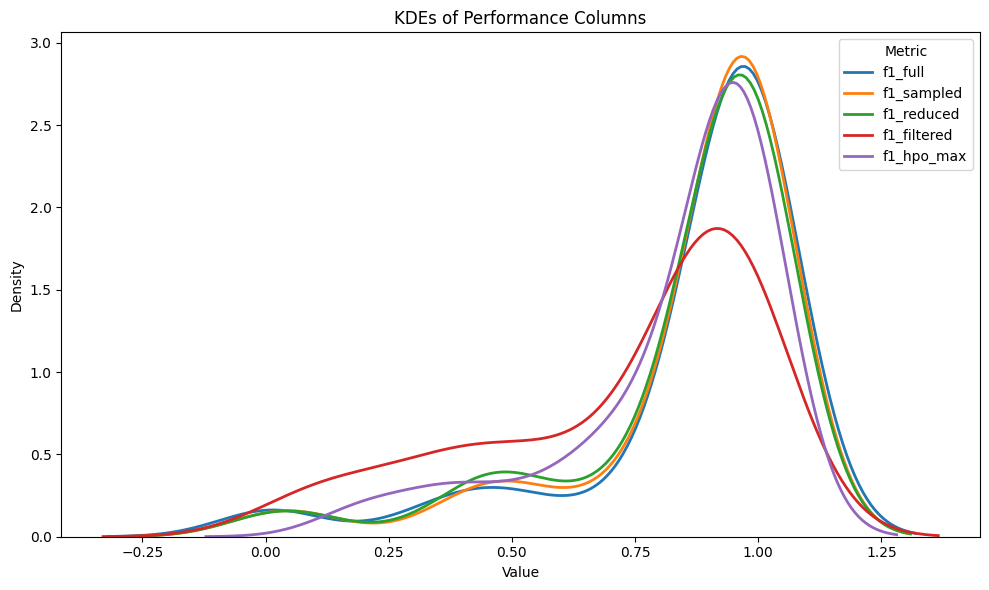

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

for col in perf_cols:
    sns.kdeplot(df_numeric[col].dropna(), label=col, linewidth=2)

plt.title("KDEs of Performance Columns")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

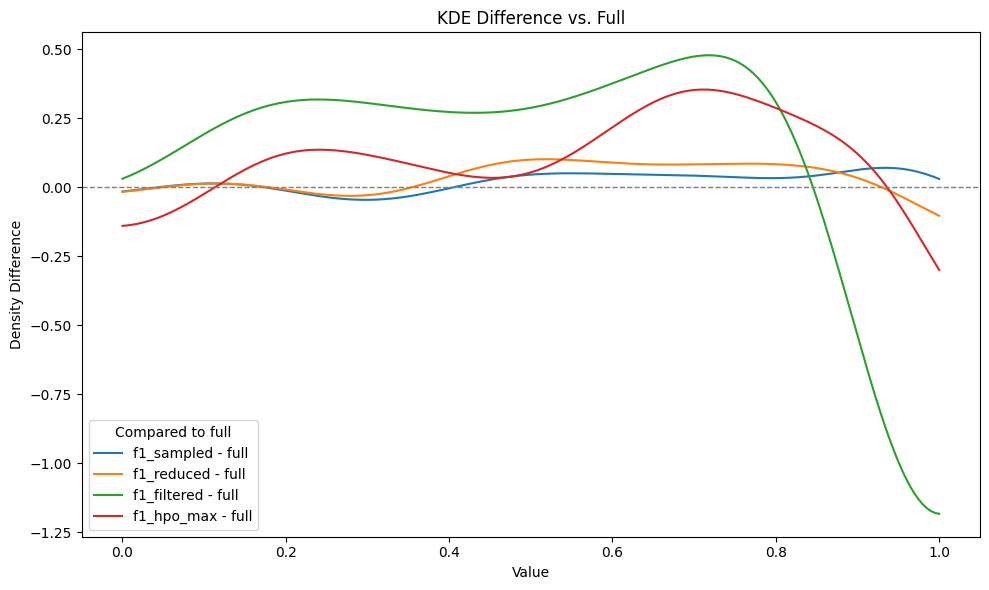

In [17]:
x_vals = np.linspace(0, 1, 200)

# Reference KDE: 'full'
ref_kde = gaussian_kde(df_numeric["f1_full"].dropna())(x_vals)

# Plot difference KDEs
plt.figure(figsize=(10, 6))

for col in perf_cols:
    if col == "f1_full":
        continue  # skip baseline
    kde_vals = gaussian_kde(df_numeric[col].dropna())(x_vals)
    diff = kde_vals - ref_kde
    plt.plot(x_vals, diff, label=f"{col} - full")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("KDE Difference vs. Full")
plt.xlabel("Value")
plt.ylabel("Density Difference")
plt.legend(title="Compared to full")
plt.tight_layout()
plt.show()

AUC difference from 'full' (higher = more different):
f1_filtered  -> 0.3607
f1_hpo_max   -> 0.1507
f1_reduced   -> 0.0511
f1_sampled   -> 0.0345


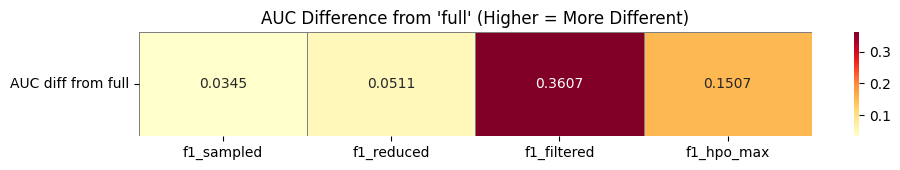

In [18]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import auc

x_vals = np.linspace(0, 1, 500)  # fine-grained KDE support
ref_kde = gaussian_kde(df_numeric["f1_full"].dropna())(x_vals)

auc_diffs = {}

for col in perf_cols:
    if col == "f1_full":
        continue
    kde_vals = gaussian_kde(df_numeric[col].dropna())(x_vals)
    diff = np.abs(kde_vals - ref_kde)
    auc_diff = auc(x_vals, diff)
    auc_diffs[col] = auc_diff

# Sort by most different
sorted_auc = sorted(auc_diffs.items(), key=lambda x: -x[1])

# Print ranking
print("AUC difference from 'full' (higher = more different):")
for method, score in sorted_auc:
    print(f"{method:12s} -> {score:.4f}")

# Create a DataFrame for heatmap
auc_df = pd.DataFrame(auc_diffs, index=["AUC diff from full"])

# Plot
plt.figure(figsize=(10, 1.8))
sns.heatmap(auc_df, annot=True, cmap="YlOrRd", fmt=".4f", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("AUC Difference from 'full' (Higher = More Different)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

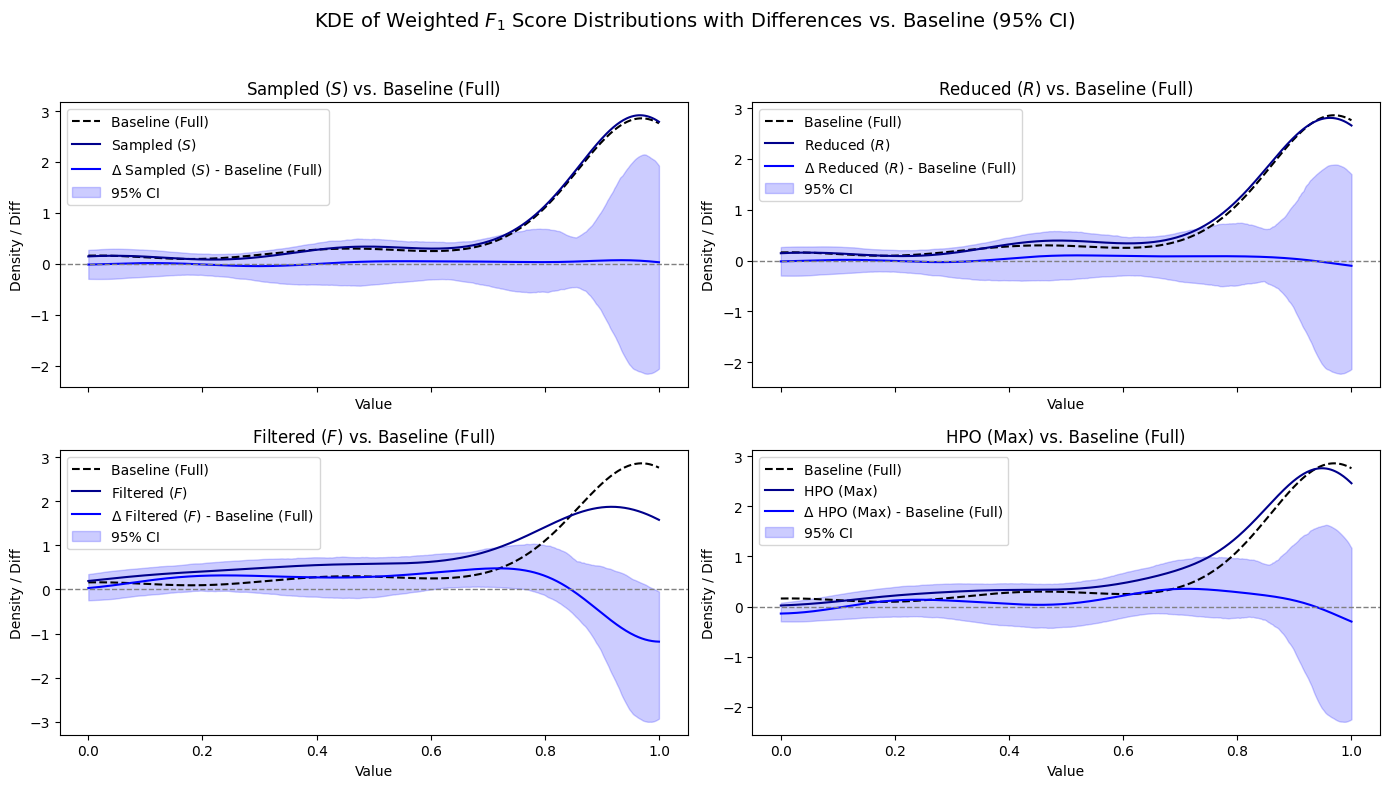

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Setup
ref_col = "f1_full"
columns = [col for col in perf_cols if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

ref_data = df_numeric[ref_col].dropna().values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

# Subplots
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)

col_map = {
    'f1_full': 'Baseline (Full)',
    'f1_sampled': 'Sampled ($S$)',
    'f1_reduced': 'Reduced ($R$)',
    'f1_filtered': 'Filtered ($F$)',
    'f1_hpo_max': 'HPO (Max)'
}

for ax, col in zip(axes.flat, columns):
    target_data = df_numeric[col].dropna().values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot KDEs
    ax.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    ax.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')

    # Overlay diff
    ax.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    ax.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{col_map[col]} vs. {col_map[ref_col]}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density / Diff")
    ax.legend()

# Cleanup
for empty_ax in axes.flat[len(columns):]:
    fig.delaxes(empty_ax)

plt.suptitle("KDE of Weighted $F_1$ Score Distributions with Differences vs. Baseline (95% CI)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

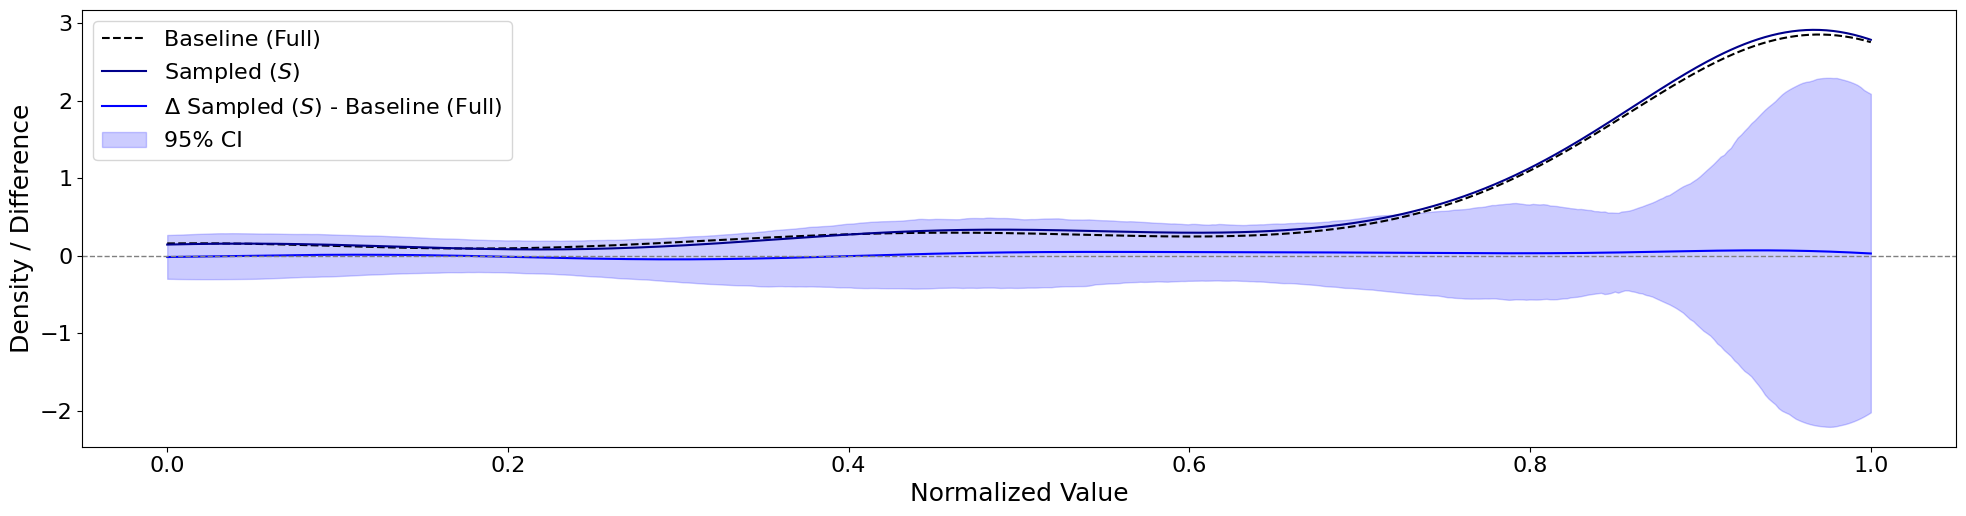

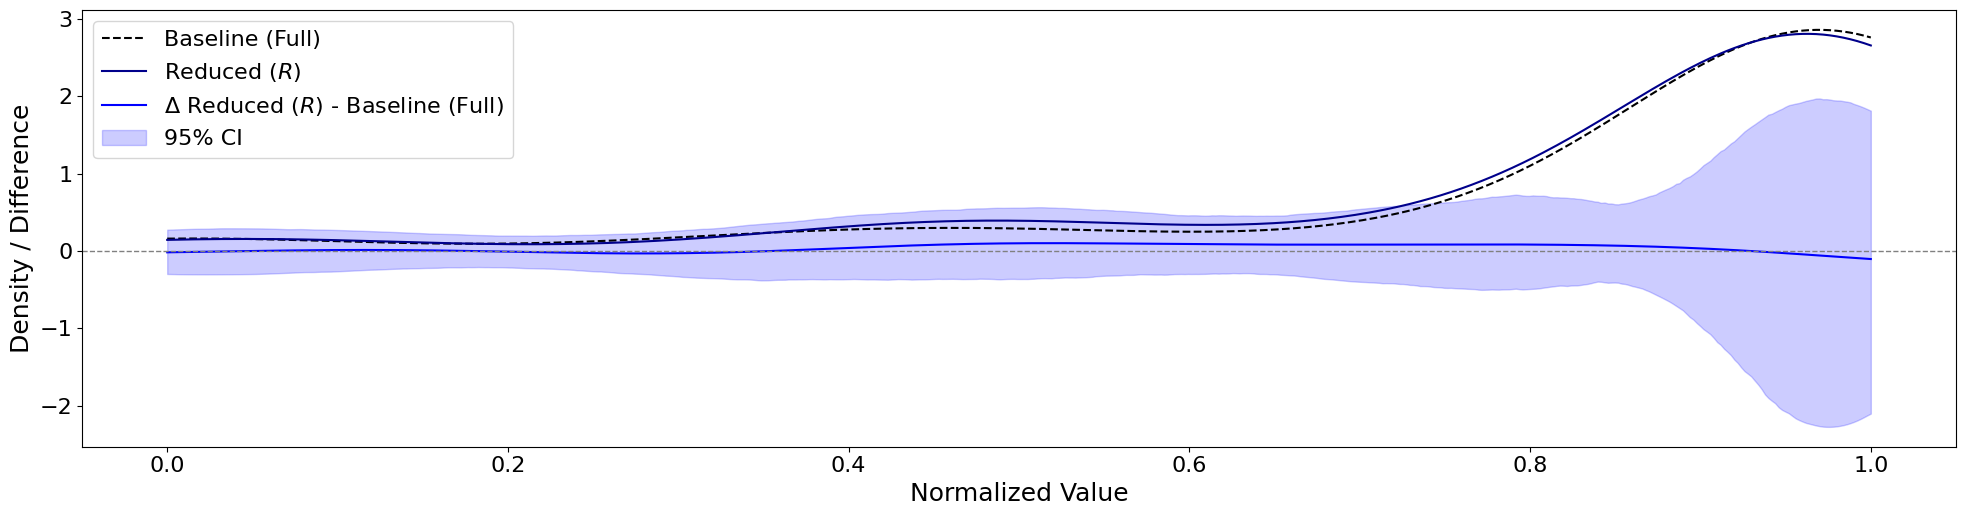

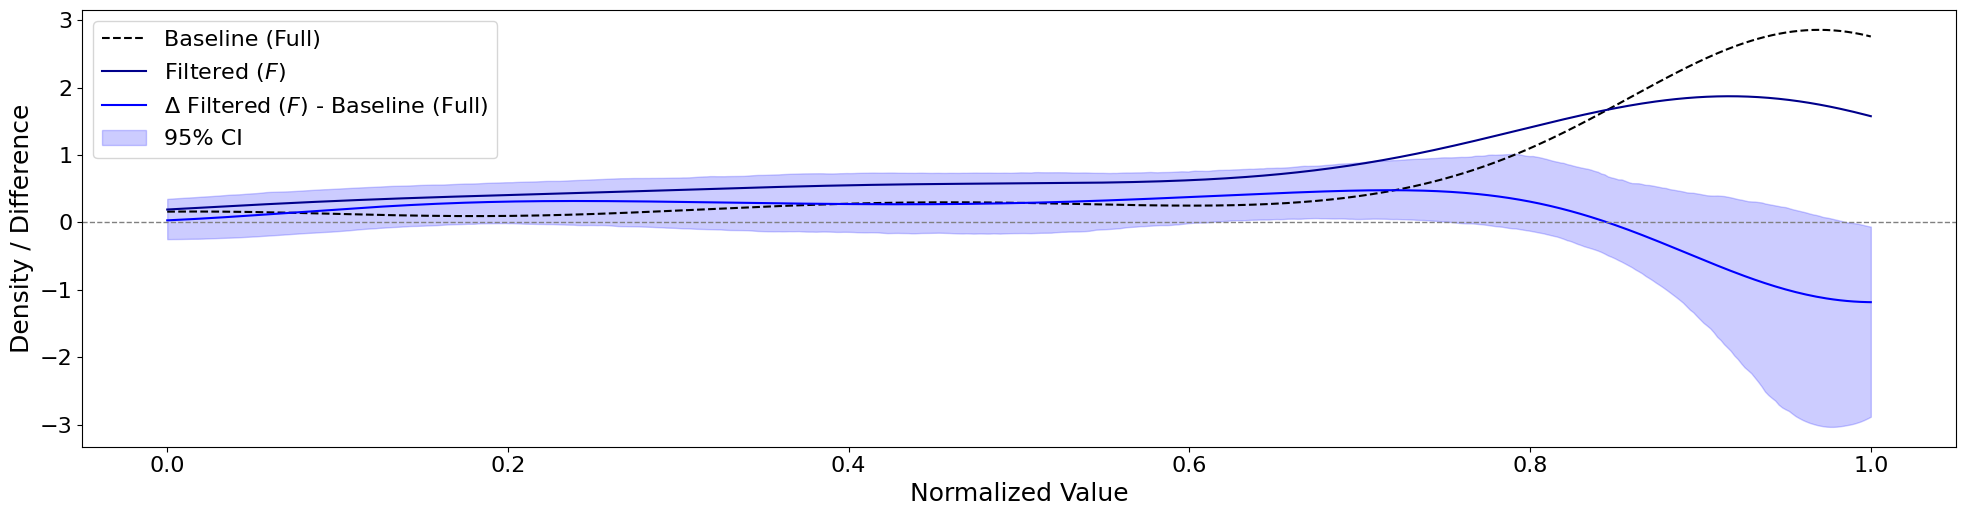

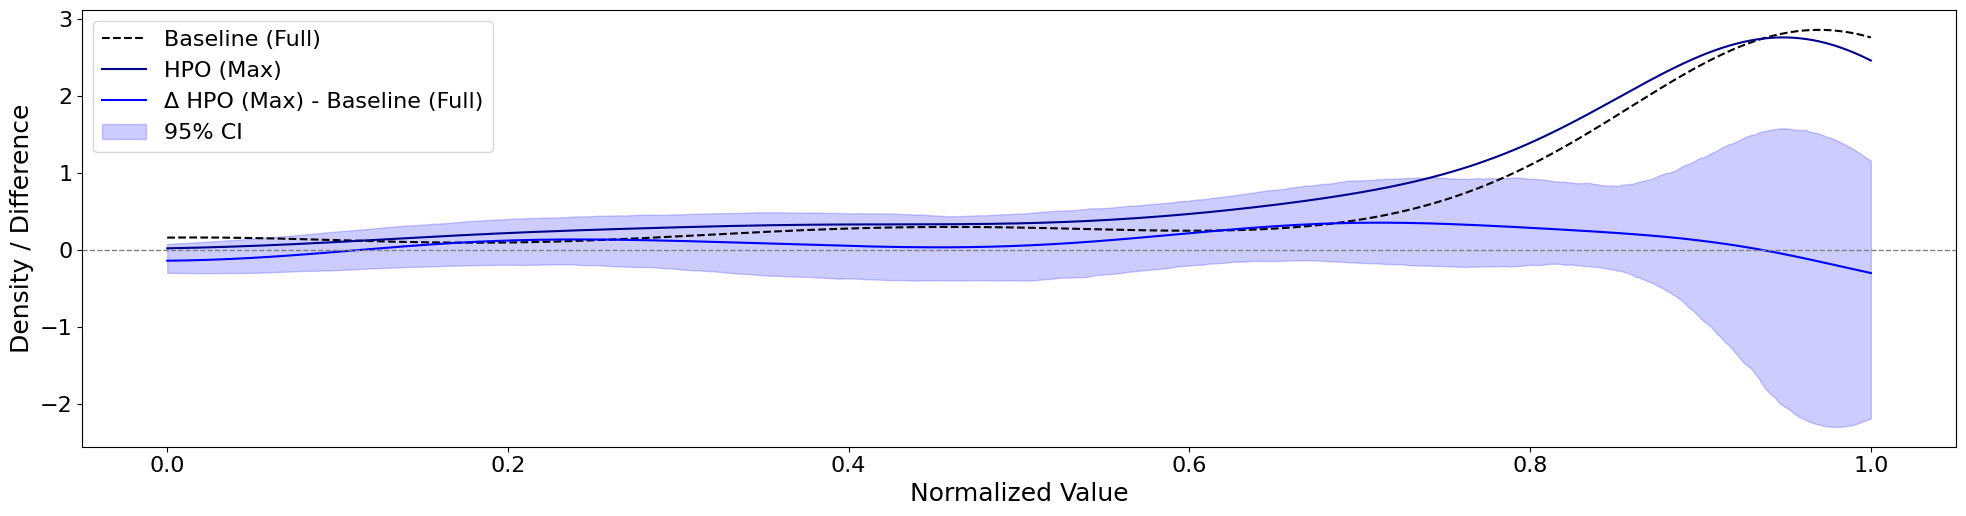

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 🔧 Set global font sizes
plt.rcParams.update({
    'font.size': 18,            # Base font size
    'axes.titlesize': 20,       # Title font
    'axes.labelsize': 18,       # Axis labels
    'xtick.labelsize': 16,      # Tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16,      # Legend
    'figure.titlesize': 22      # Figure title
})

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Setup
ref_col = "f1_full"
columns = [col for col in perf_cols if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

ref_data = df_numeric[ref_col].dropna().values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'f1_full': 'Baseline (Full)',
    'f1_sampled': 'Sampled ($S$)',
    'f1_reduced': 'Reduced ($R$)',
    'f1_filtered': 'Filtered ($F$)',
    'f1_hpo_max': 'HPO (Max)'
}

for col in columns:
    target_data = df_numeric[col].dropna().values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    plt.figure(figsize=(20, 5.5))
    plt.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    plt.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    plt.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Labels
    plt.xlabel("Normalized Value")
    plt.ylabel("Density / Difference")
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}.pdf", dpi=300)
    plt.show()
    plt.close()

# Training Time Analysis

In [21]:
# Columns to compare against "full"
cols_to_compare = ['time_sampled', 'time_reduced', 'time_filtered', 'time_hpo_min']

# Make a numeric copy to compute differences safely
df_numeric = df_pretty.copy()

# Compute best alternative and delta
# best_alternative = df_numeric[cols_to_compare].max(axis=1)
# df_pretty['time_delta_abs'] = best_alternative - df_numeric['time_full']
# df_pretty['time_delta_pct'] = df_pretty['time_delta_abs'] / df_numeric['time_full']

# # Enforce +/- signs and percentage for 2nd col
# df_pretty['time_delta_abs'] = df_pretty['time_delta_abs'].map(lambda x: f"{x:+.3f}")
# df_pretty['time_delta_pct'] = df_pretty['time_delta_pct'].apply(lambda x: f"{x * 100:+.2f}")

# Apply to your DataFrame
df_pretty = format_and_pad_all_columns(df_pretty.loc[custom_order])

# Export to .tex with aligned source formatting
# df_pretty.to_latex("table_3.tex", header=True, index=True, escape=False)
selected_cols = ["time_full", "time_sampled", "time_reduced", "time_filtered", "time_hpo_min"]
with open("table_3.tex", "w") as f:
    df_pretty_chopped = df_pretty[selected_cols]
    df_pretty_chopped = format_and_pad_all_columns(df_pretty_chopped.loc[custom_order])
    f.write(df_pretty_chopped.to_string())

df_pretty[selected_cols]

,time_full,time_sampled,time_reduced,time_filtered,time_hpo_min
filename,,,,,
CIC_IDS_2017_Multiclass,7.2,7.6,9.6,3.3,4.3
CIC_IOT_Dataset2023_Multiclass,123.3,38.0,35.9,6.7,14.0
IoT_23_Multiclass,8.2,5.9,6.5,2.1,4.0
IoT_Network_Intrusion_Macro_Multiclass,2.8,2.2,2.0,2.0,2.1
IoT_Network_Intrusion_Micro_Multiclass,6.3,2.8,2.6,2.4,3.3
KDD_Cup_1999_Multiclass,13.0,8.6,5.2,1.1,3.3
UNSW_NB15_Multiclass,4.9,3.8,3.7,3.1,3.5
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,25.0,5.8,4.3,3.6,6.6
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,4.8,3.1,3.9,9.0,4.8


In [22]:
df_pretty.shape

(73, 29)

In [23]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols = ['time_full', 'time_sampled', 'time_reduced', 'time_filtered', 'time_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_numeric.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols + [target_col]]
        .corr(method=method)
        .loc[perf_cols, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all = pd.DataFrame(corr_data)
df_corr_all.index.name = 'metric'
df_corr_all.reset_index(inplace=True)

# Export to .tex with aligned source formatting
# df_pretty.to_latex("table_3.tex", header=True, index=True, escape=False)
with open("table_4.tex", "w") as f:
    f.write(format_and_pad_all_columns(df_corr_all).to_string())

df_corr_all

,metric,pearson,spearman,kendall
0,time_full,-0.045155,-0.049338,-0.050694
1,time_sampled,-0.178384,-0.228182,-0.157849
2,time_reduced,-0.109344,-0.169392,-0.116557
3,time_filtered,-0.041703,-0.033192,-0.025284
4,time_hpo_min,-0.203027,-0.243002,-0.158526


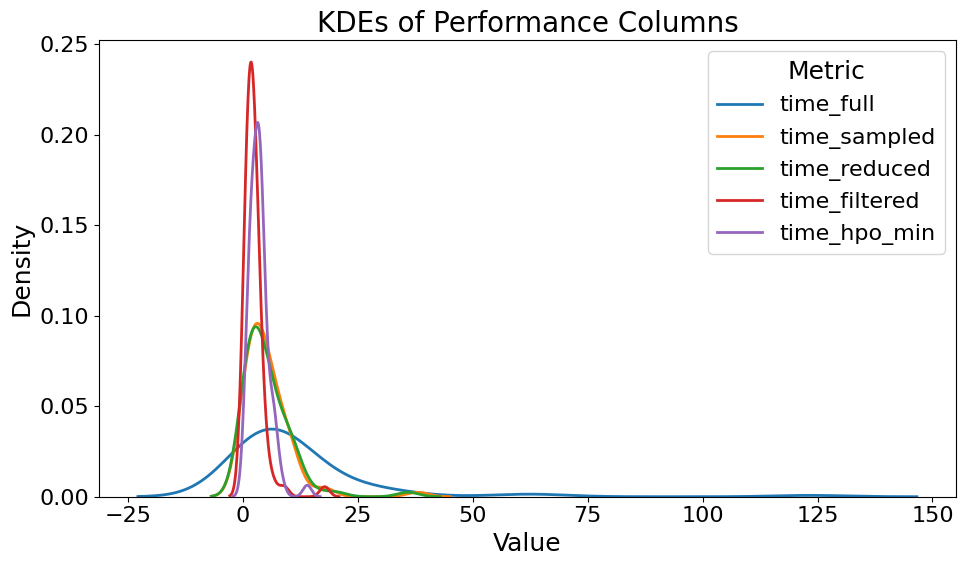

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

for col in perf_cols:
    sns.kdeplot(df_numeric[col].dropna(), label=col, linewidth=2)

plt.title("KDEs of Performance Columns")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

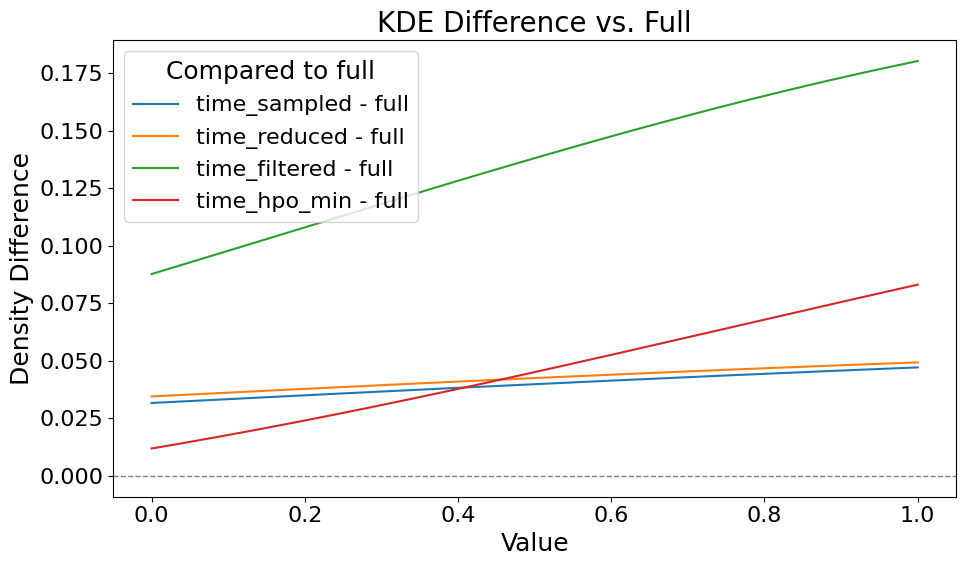

In [25]:
x_vals = np.linspace(0, 1, 200)

# Reference KDE: 'full'
ref_kde = gaussian_kde(df_numeric["time_full"].dropna())(x_vals)

# Plot difference KDEs
plt.figure(figsize=(10, 6))

for col in perf_cols:
    if col == "time_full":
        continue  # skip baseline
    kde_vals = gaussian_kde(df_numeric[col].dropna())(x_vals)
    diff = kde_vals - ref_kde
    plt.plot(x_vals, diff, label=f"{col} - full")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("KDE Difference vs. Full")
plt.xlabel("Value")
plt.ylabel("Density Difference")
plt.legend(title="Compared to full")
plt.tight_layout()
plt.show()

AUC difference from 'full' (higher = more different):
time_filtered -> 0.1366
time_hpo_min -> 0.0459
time_reduced -> 0.0423
time_sampled -> 0.0397


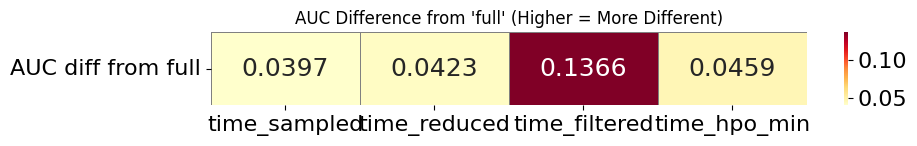

In [26]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import auc

x_vals = np.linspace(0, 1, 500)  # fine-grained KDE support
ref_kde = gaussian_kde(df_numeric["time_full"].dropna())(x_vals)

auc_diffs = {}

for col in perf_cols:
    if col == "time_full":
        continue
    kde_vals = gaussian_kde(df_numeric[col].dropna())(x_vals)
    diff = np.abs(kde_vals - ref_kde)
    auc_diff = auc(x_vals, diff)
    auc_diffs[col] = auc_diff

# Sort by most different
sorted_auc = sorted(auc_diffs.items(), key=lambda x: -x[1])

# Print ranking
print("AUC difference from 'full' (higher = more different):")
for method, score in sorted_auc:
    print(f"{method:12s} -> {score:.4f}")

# Create a DataFrame for heatmap
auc_df = pd.DataFrame(auc_diffs, index=["AUC diff from full"])

# Plot
plt.figure(figsize=(10, 1.8))
sns.heatmap(auc_df, annot=True, cmap="YlOrRd", fmt=".4f", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("AUC Difference from 'full' (Higher = More Different)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

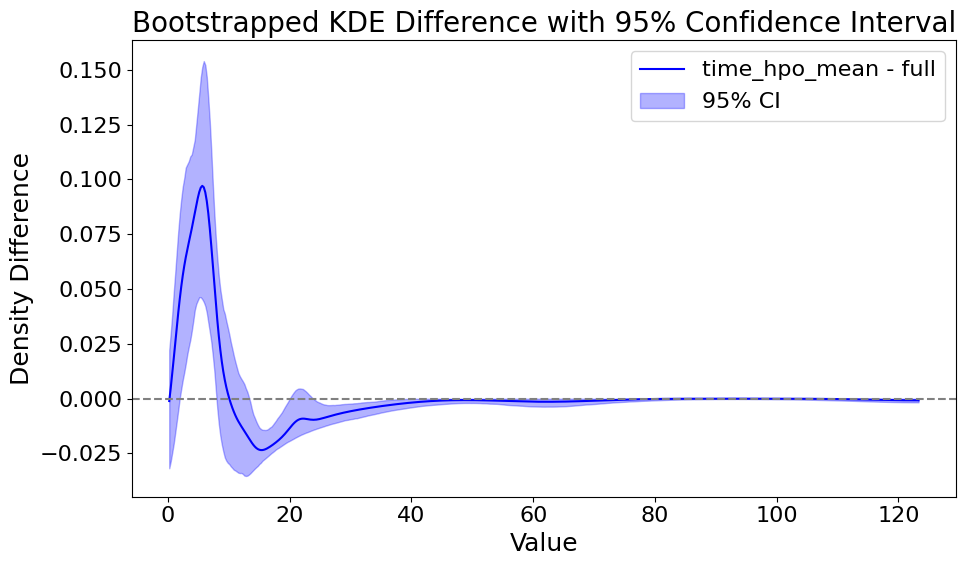

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)

    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Example for a single method vs. 'full'
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

df_numeric["time_full"] = pd.to_numeric(df_numeric["time_full"], errors="coerce")
ref_data = df_numeric["time_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

target = "time_hpo_mean"
df_numeric[target] = pd.to_numeric(df_numeric[target], errors="coerce")
target_data = df_numeric[target].dropna().astype(float).values
target_kde = gaussian_kde(target_data)(x_vals)
target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

# Difference and CI
diff = target_kde - ref_kde
diff_lower = target_lower - ref_upper  # Conservative lower bound
diff_upper = target_upper - ref_lower  # Conservative upper bound

# Plot difference ± CI
plt.figure(figsize=(10, 6))
plt.plot(x_vals, diff, label=f"{target} - full", color='blue')
plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.3, color='blue', label="95% CI")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Bootstrapped KDE Difference with 95% Confidence Interval")
plt.xlabel("Value")
plt.ylabel("Density Difference")
plt.legend()
plt.tight_layout()
plt.show()

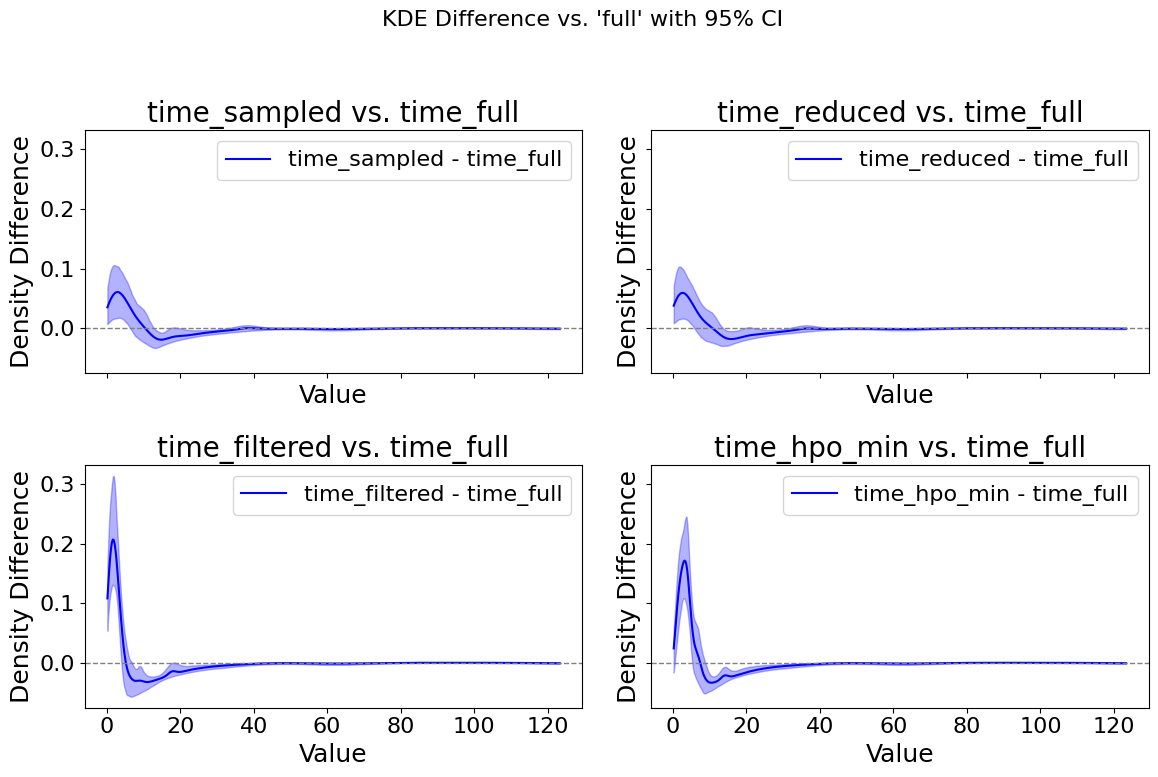

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Setup
ref_col = "time_full"
columns = [col for col in perf_cols if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

df_numeric["time_full"] = pd.to_numeric(df_numeric["time_full"], errors="coerce")
ref_data = df_numeric["time_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

# Subplot grid setup
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=True, sharey=True)

for ax, col in zip(axes.flat, columns):
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    ax.plot(x_vals, diff, label=f"{col} - {ref_col}", color='blue')
    ax.fill_between(x_vals, diff_lower, diff_upper, alpha=0.3, color='blue')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{col} vs. {ref_col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density Difference")
    ax.legend()

# Clean layout
for empty_ax in axes.flat[len(columns):]:
    fig.delaxes(empty_ax)

plt.suptitle("KDE Difference vs. 'full' with 95% CI", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

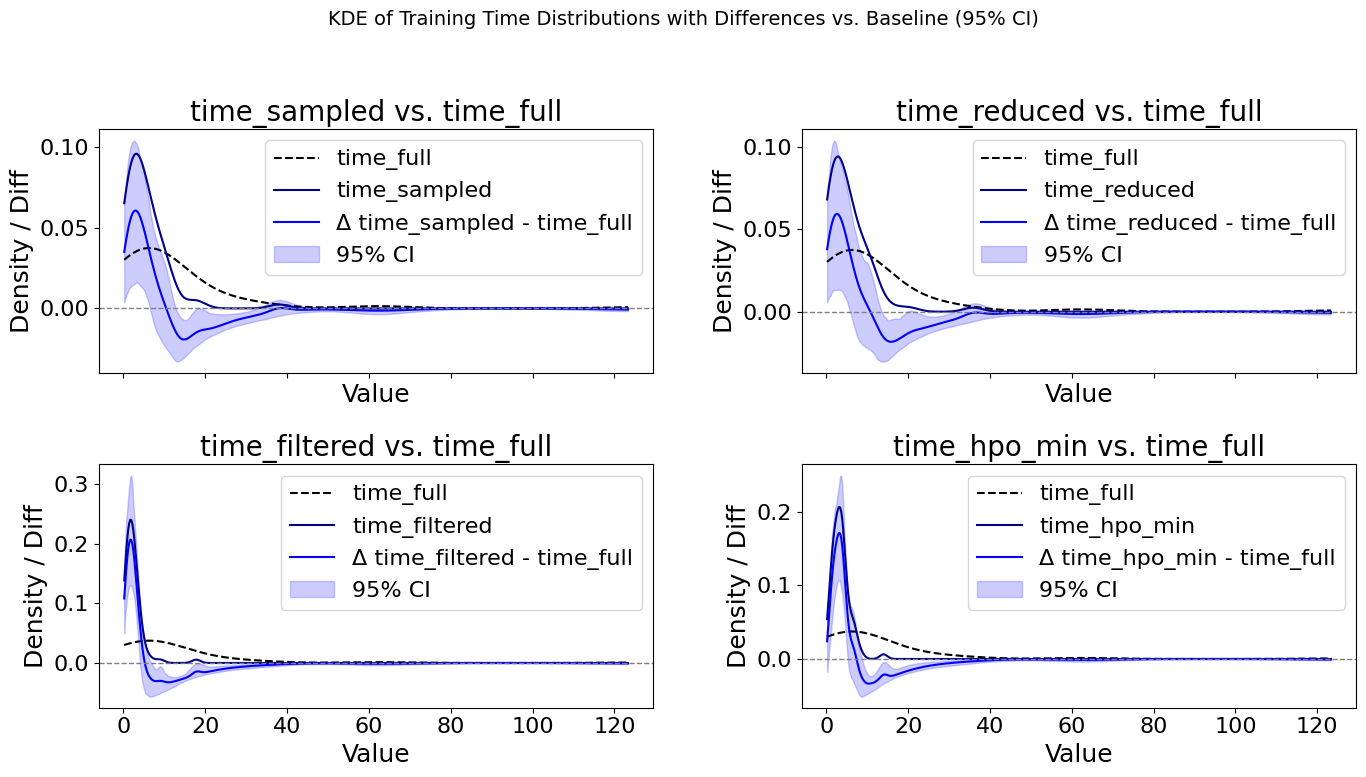

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Setup
ref_col = "time_full"
columns = [col for col in perf_cols if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

df_numeric["time_full"] = pd.to_numeric(df_numeric["time_full"], errors="coerce")
ref_data = df_numeric["time_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

# Subplots
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)

for ax, col in zip(axes.flat, columns):
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot KDEs
    ax.plot(x_vals, ref_kde, label=f"{ref_col}", color='black', linestyle='--')
    ax.plot(x_vals, target_kde, label=f"{col}", color='darkblue')

    # Overlay diff
    ax.plot(x_vals, diff, label=f"Δ {col} - {ref_col}", color='blue')
    ax.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{col} vs. {ref_col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density / Diff")
    ax.legend()

# Cleanup
for empty_ax in axes.flat[len(columns):]:
    fig.delaxes(empty_ax)

plt.suptitle("KDE of Training Time Distributions with Differences vs. Baseline (95% CI)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

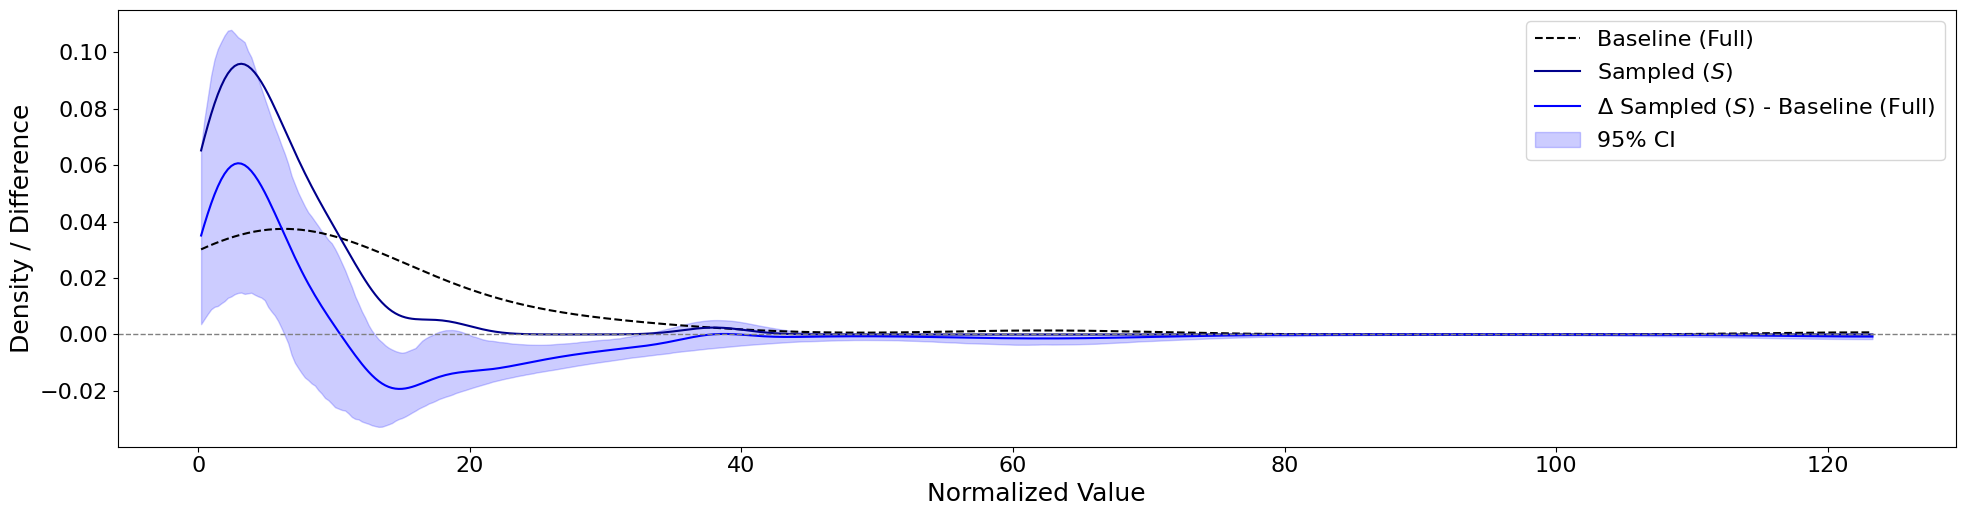

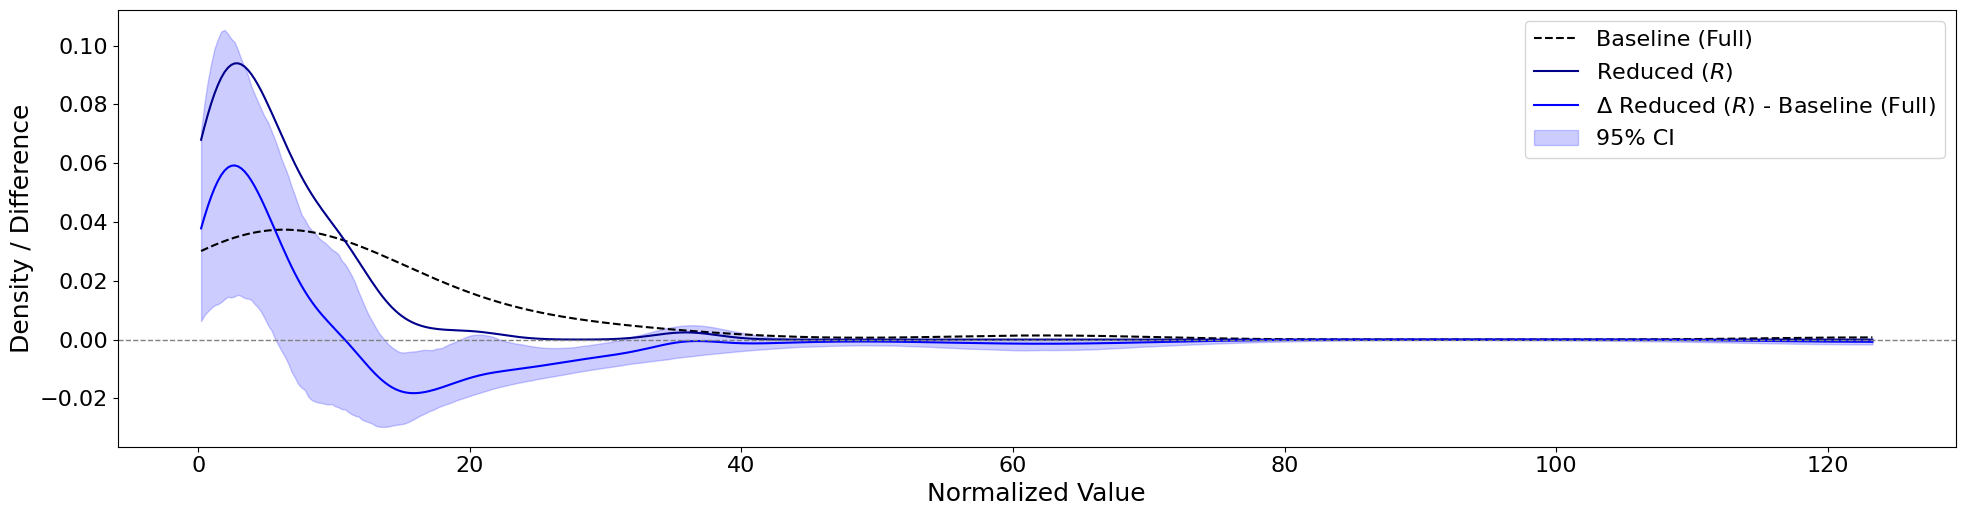

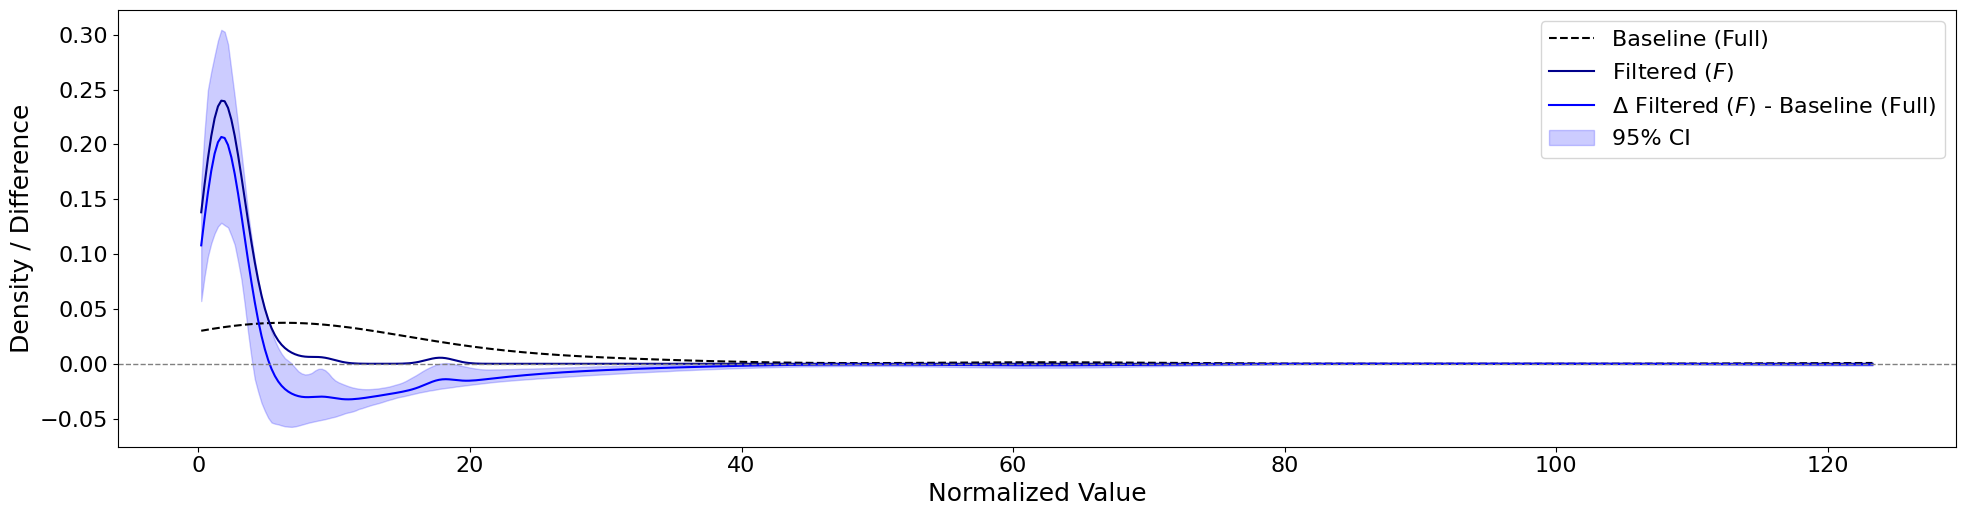

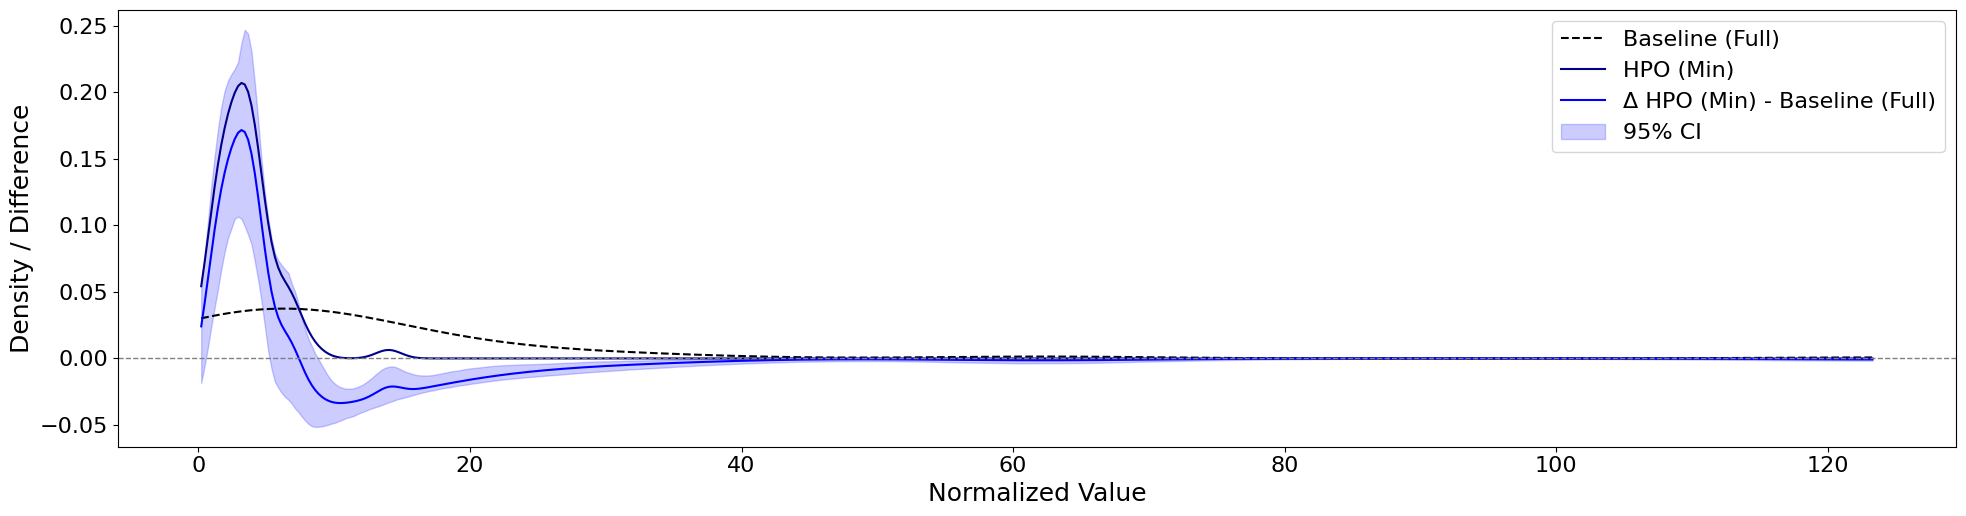

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 🔧 Set global font sizes
plt.rcParams.update({
    'font.size': 18,            # Base font size
    'axes.titlesize': 20,       # Title font
    'axes.labelsize': 18,       # Axis labels
    'xtick.labelsize': 16,      # Tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16,      # Legend
    'figure.titlesize': 22      # Figure title
})

def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# Setup
ref_col = "time_full"
columns = [col for col in perf_cols if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols].min().min(),
                     df_numeric[perf_cols].max().max(), 500)

df_numeric["time_full"] = pd.to_numeric(df_numeric["time_full"], errors="coerce")
ref_data = df_numeric["time_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'time_full': 'Baseline (Full)',
    'time_sampled': 'Sampled ($S$)',
    'time_reduced': 'Reduced ($R$)',
    'time_filtered': 'Filtered ($F$)',
    'time_hpo_min': 'HPO (Min)'
}

for col in columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    plt.figure(figsize=(20, 5.5))
    plt.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    plt.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    plt.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Labels
    plt.xlabel("Normalized Value")
    plt.ylabel("Density / Difference")
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}.pdf", dpi=300)
    plt.show()
    plt.close()

# ----

In [31]:
def summarize_results(df_filename, results_filename):
    df = pd.read_excel(results_filename)
    row_full = df.loc[df['Unnamed: 0'] == 'full', 'X_train_shape'].values[0]
    row_max = df.loc[df['f1_score_abs'].idxmax()].to_dict()
    if 'Unnamed: 0' in row_max:
        row_max['best_config'] = row_max.pop('Unnamed: 0')
    summary = {'filename': df_filename, 'shape': row_full,}
    summary.update(row_max)
    return summary

In [32]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-06-28/Output_Multiclass")

summary_rows = []

# Find all .parquet files recursively
result_files = list(base_folder.rglob("*table.xlsx"))

# Iterate
for file in tqdm(result_files, desc='File', leave='False'):

    try:
        short_filename = str(file.parent.stem)
        row = summarize_results(short_filename, file)
        summary_rows.append(row)
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/66 [00:00<?, ?it/s]

In [33]:
output_df = pd.DataFrame(summary_rows).set_index("filename")

output_df

,shape,X_train_shape,X_val_shape,X_test_shape,model_size_abs,model_size_delta,training_time_abs,training_time_delta,latency_abs,latency_delta,f1_score_abs,f1_score_delta,hpo_n_trials,hpo_params,best_config
filename,,,,,,,,,,,,,,,
CICEVSE2024_EVSE-B_Macro_Multiclass,"(171987, 68)","(17190, 68)","(57329, 68)","(57329, 68)",1.36,-0.48 (-26.09%),3.851,-2.049717 (-34.74%),3.865710e-07,-6.18e-07 (-61.51%),0.948975,+0.001143 (+0.11%),--,--,sampled
NIDS_NF-ToN-IoT-v2_Multiclass,"(699477, 38)","(699477, 38)","(233159, 38)","(233158, 38)",10.85,+0.00 (+0.00%),33.318,--,4.431470e-07,--,0.887541,--,--,--,full
ToN_IoT_Network_Multiclass,"(282243, 40)","(282243, 40)","(94081, 40)","(94081, 40)",6.51,+0.00 (+0.00%),20.285,--,6.354210e-07,--,0.982596,--,--,--,full
N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass,"(329363, 115)","(329363, 115)","(109788, 115)","(109787, 115)",2.39,+0.00 (+0.00%),10.981,--,5.893960e-07,--,0.999852,--,--,--,full
NIDS_NF-BoT-IoT-v2_Multiclass,"(85853, 38)","(85853, 38)","(28617, 38)","(28617, 38)",8.56,+0.00 (+0.00%),12.962,--,2.923850e-06,--,0.907984,--,--,--,full
NIDS_CIC-ToN-IoT_Multiclass,"(101735, 71)","(10176, 31)","(33911, 31)","(33911, 31)",0.93,-0.53 (-36.30%),3.128,+0.009085 (+0.29%),3.329400e-07,-2.21e-07 (-39.86%),0.880905,+0.010080 (+1.01%),--,--,reduced
N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass,"(471723, 115)","(471723, 115)","(157241, 115)","(157240, 115)",2.32,+0.00 (+0.00%),13.062,--,4.514050e-07,--,0.999910,--,--,--,full
ToN_IoT_Linux_Disk_Multiclass,"(14495, 5)","(1445, 5)","(4832, 5)","(4831, 5)",1.38,-2.80 (-66.99%),1.187,-1.543635 (-56.53%),1.860366e-06,-2.00e-08 (-1.07%),0.580356,+0.029170 (+2.92%),--,--,sampled
CICAPT_IIoT_Phase2_Macro_Multiclass,"(4925659, 48)","(4925659, 48)","(1641886, 48)","(1641886, 48)",6.48,+0.00 (+0.00%),92.517,--,6.500510e-07,--,0.999988,--,--,--,full


In [34]:
summary_df = input_df.data.join(output_df, how='left')

summary_df

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty,shape,X_train_shape,X_val_shape,X_test_shape,model_size_abs,model_size_delta,training_time_abs,training_time_delta,latency_abs,latency_delta,f1_score_abs,f1_score_delta,hpo_n_trials,hpo_params,best_config
filename,,,,,,,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,48.120055,1250066,70,15,"{int64, int32, category}",mixed,0.516218,"(750040, 70)","(750040, 70)","(250013, 70)","(250013, 70)",2.70,+0.00 (+0.00%),11.012,--,3.059430e-07,--,0.999263,--,--,--,full
CIC_IOT_Dataset2023_Multiclass,103.467662,4487800,39,35,"{float64, float32, int64, int32, category}",mixed,0.463669,"(2692680, 39)","(2692680, 39)","(897560, 39)","(897560, 39)",52.26,+0.00 (+0.00%),169.606,--,1.402096e-06,--,0.768569,--,--,--,full
IoT_23_Multiclass,1.983605,363889,12,16,"{float32, int32, category}",mixed,0.654002,"(218338, 12)","(218338, 12)","(72779, 12)","(72779, 12)",2.67,+0.00 (+0.00%),10.503,--,1.020621e-06,--,0.992632,--,--,--,full
IoT_Network_Intrusion_Macro_Multiclass,0.388587,78938,24,5,"{float64, int32, category}",mixed,0.581516,"(129388, 26)","(129388, 26)","(43129, 26)","(43129, 26)",216.99,+0.00 (+0.00%),17.221,--,4.683520e-07,--,0.973631,--,--,--,full
IoT_Network_Intrusion_Micro_Multiclass,0.388876,78963,24,11,"{float64, int32, category}",mixed,0.578433,"(129388, 26)","(129388, 26)","(43129, 26)","(43129, 26)",282.62,+0.00 (+0.00%),24.907,--,2.333477e-06,--,0.971362,--,--,--,full
KDD_Cup_1999_Multiclass,6.023224,1074992,40,23,"{int64, float32, int32, category}",mixed,0.533156,"(645000, 40)","(645000, 40)","(215000, 40)","(214999, 40)",2.34,+0.00 (+0.00%),15.210,--,5.560210e-07,--,0.999785,--,--,--,full
UNSW_NB15_Multiclass,46.291736,1944769,45,11,"{float64, float32, int64, int32, category}",mixed,0.597476,"(1166862, 45)","(1166862, 45)","(388954, 45)","(388953, 45)",3.13,+0.00 (+0.00%),7.885,--,1.458650e-07,--,0.982184,--,--,--,full
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.335672,292898,73,12,"{float64, float32, int64, int32, category}",mixed,0.572254,"(175739, 73)","(175739, 73)","(58580, 73)","(58579, 73)",10.69,+0.00 (+0.00%),20.965,--,2.674412e-06,--,0.755286,--,--,--,full
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{float64, float32, int64, int32, category}",mixed,0.519524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
summary_df.to_excel("/home/automl/git/iot-threat-classifier/2025-06-28/summary.xlsx")

In [36]:
summary_df[summary_df.isna().any(axis=1)]

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty,shape,X_train_shape,X_val_shape,X_test_shape,model_size_abs,model_size_delta,training_time_abs,training_time_delta,latency_abs,latency_delta,f1_score_abs,f1_score_delta,hpo_n_trials,hpo_params,best_config
filename,,,,,,,,,,,,,,,,,,,,,,
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{float64, float32, int64, int32, category}",mixed,0.519524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass,6.598314,91787,72,2,"{int64, float32, int32, category}",mixed,0.460704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CICAPT_IIoT_Phase1_Macro_Multiclass,101.821614,10260159,48,1,"{float64, float32, int64, int32, category}",mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CICAPT_IIoT_Phase1_Micro_Multiclass,101.821614,10260159,48,1,"{float64, float32, int64, int32, category}",mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CICIoMT2024_Bluetooth_Multiclass,0.008513,747,7,2,"{float64, float32, int32}",numerical,0.538772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ToN_IoT_IoT_Garage_Door_Multiclass,0.002548,18,2,8,{category},categorical,0.725050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ToN_IoT_IoT_Motion_Light_Multiclass,0.002620,16,2,8,"{int64, category}",mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
summary_df[summary_df.isna().any(axis=1)].to_excel("/home/automl/git/iot-threat-classifier/2025-06-28/errors.xlsx")